In [2]:
%load_ext autoreload
%autoreload 2

In [148]:
from multitask.benchmarks.kinetic_models import(
    StereoSelectiveReaction, 
    create_pcs_ds,
    MultitaskKinetics
)
from multitask.strategies import NewSTBO, NewMTBO
from summit.utils.multiobjective import pareto_efficient
from summit import *
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## Stereo Selective Reaction

### Load Data

In [148]:
#Constants
DATA_PATH   =  '../data/'
SOLVENT_DESCRIPTOR_DATA_FILE =  DATA_PATH + 'solvent_descriptors.csv'
SOLVENT_INDEX = 'cas_number'
SOLVENT_METADATA_VARIABLES = ['stenutz_name', 'cosmo_name', 'chemical_formula']
UCB_PHARMA_APPROVED_LIST = DATA_PATH + 'ucb_pharma_approved_list.csv'
SOLUBILITIES_DATA_FILE = DATA_PATH + "solvent_solubilities.csv"


#Load solvent descriptor dataset
_solvent_candidates = pd.read_csv(SOLVENT_DESCRIPTOR_DATA_FILE)
_solvent_candidates = _solvent_candidates.set_index(SOLVENT_INDEX)
solvent_ds = DataSet.from_df(_solvent_candidates, metadata_columns=SOLVENT_METADATA_VARIABLES)

#Load UCB Pharma approved list
ucb_list = pd.read_csv(UCB_PHARMA_APPROVED_LIST)
ucb_list = ucb_list.set_index('cas_number')
ucb_ds = DataSet.from_df(ucb_list, metadata_columns=['solvent_class', 'solvent_name'])

# Solubilities datset
solubilities = pd.read_csv(SOLUBILITIES_DATA_FILE)
solubilities = solubilities.set_index("cas_number")
solubilities = DataSet.from_df(solubilities)

### Descriptors

In [149]:
solvent_ds_pcs, pca = create_pcs_ds(
    solvent_ds,
    ucb_ds,
    solubilities,
    num_components=3, 
    ucb_filter=True, 
    verbose=True
)

80 solvents for optimization
70% of variance is explained by 3 principal components.


In [150]:
pd.DataFrame(
    pca.components_.T, 
    index=solvent_ds.data_columns + ['solubility'], 
    columns=solvent_ds_pcs.data_columns
).sort_values('PC_1')

,PC_1,PC_2,PC_3
partition_coefficient,-0.350498,-0.012300,0.252559
sigma_2,-0.316189,0.267132,0.074034
molar_volume,-0.295616,0.276469,0.047847
molecular_refractive_power,-0.273993,0.325531,0.106905
molecular_weight,-0.163227,0.390747,0.067756
vapour_pressure,-0.087970,-0.242292,-0.066203
refractive_index,-0.032506,0.205296,0.202902
boiling_point,0.135144,0.408971,0.104810
sigma_5,0.153697,0.300914,-0.261709
viscosity,0.156539,0.147958,0.441249


### Benchmark 

 <ipython-input-153-a2e1fe9c44b0>:17: RuntimeWarning:invalid value encountered in true_divide


Text(0, 0.5, '%')

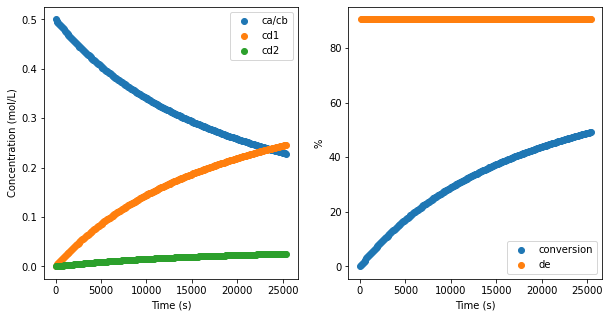

In [153]:
random_state = np.random.RandomState(100)
exp = StereoSelectiveReaction(solvent_ds_pcs, random_state)
x = exp._integrate_rate('616-38-6', rxn_time=25200, step_size=100)

fig, axes = plt.subplots(1, 2, figsize=(10,5))
trange = np.linspace(0, 25400, x.shape[0])
cd1 = x[:, 0]
cd2 = x[:, 1]

axes[0].scatter(trange, 0.5-x[:,0]-x[:,1], label='ca/cb')
axes[0].scatter(trange, cd1, label='cd1')
axes[0].scatter(trange, cd2, label='cd2')
axes[0].legend(); axes[0].set_xlabel('Time (s)');
axes[0].set_ylabel('Concentration (mol/L)')

axes[1].scatter(trange, cd1/0.5*100, label='conversion')
axes[1].scatter(trange, cd1/(cd1+cd2)*100, label='de')
axes[1].legend(); axes[1].set_xlabel('Time (s)');
axes[1].set_ylabel('%')

In [7]:
random_state = np.random.RandomState(100)
exp = StereoSelectiveReaction(solvent_ds_pcs, random_state)
conditions = DataSet(solvent_ds_pcs.index.values, columns=["solvent"])
all_experiments = exp.run_experiments(conditions) 

In [8]:
all_experiments.sort_values("conversion")

,solvent,conversion,de,computation_t,experiment_t,strategy
36,110-54-3,5.496149,10.233521,0.0,0.023238,NaN
74,540-84-1,30.933193,46.7698,0.0,0.025093,NaN
33,142-82-5,32.142435,48.177143,0.0,0.025187,NaN
0,56-81-5,32.652662,44.998815,0.0,0.029263,NaN
70,111-87-5,43.528419,63.347235,0.0,0.025057,NaN
...,...,...,...,...,...,...
5,96-49-1,79.768892,93.323434,0.0,0.028063,NaN
55,67-64-1,81.040237,89.693131,0.0,0.029093,NaN
65,68-12-2,81.244445,92.247595,0.0,0.027239,NaN
47,126-33-0,81.275079,92.771324,0.0,0.026961,NaN


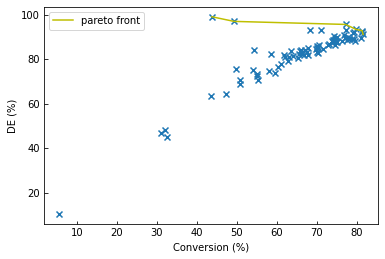

In [9]:
pareto, pareto_indices = pareto_efficient(
    all_experiments[["conversion", "de"]].to_numpy()
)
pareto = pd.DataFrame(pareto).sort_values(0).to_numpy()
ax = plt.subplot(111)
ax.set_xlabel('Conversion (%)'); ax.set_ylabel('DE (%)')
ax.scatter(all_experiments["conversion"], all_experiments["de"], marker='x')
ax.plot(pareto[:, 0], pareto[:, 1], c='y', label='pareto front')
ax.legend()
ax.tick_params(direction='in')
# plt.savefig('outputs/solvent_optimization_experiment_space.png')
# plt.savefig('outputs/solvent_optimization_experiment_space.svg')

### Optimization

In [10]:
random_state = np.random.RandomState(100)
exp = StereoSelectiveReaction(
    solvent_ds_pcs.iloc[:50], random_state, use_descriptors=False
)
strategy = TSEMO(exp.domain, n_spectral_points=100)
r = Runner(strategy=strategy, experiment=exp, max_iterations=10, batch_size=10)
r.run()

 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-k0YbXS9f-py3.9/lib/python3.9/site-packages/summit/experiment.py:234: UserWarning:No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot: xlabel='conversion', ylabel='de'>)

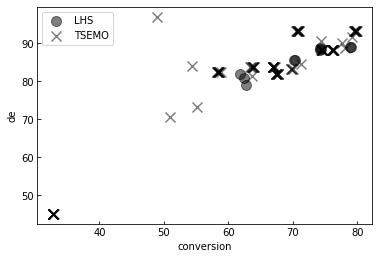

In [12]:
r.experiment.pareto_plot()

## Catalyst and Solvent Kinetic Network

Reaction:

Cat -> Pre-cat + Lig (k0) - Induction

SM1 + SM2 + Lig -> Product + Lig (k1) - main reaction

SM2 + SM2 + Lig -> Impurity1 + Lig (k2) - homocoupling

SM2 -> Impurity2 (k3) - side reaction (e.g., protodeboronation)

Product -> Impurity3 (k4)  - cleavage of product

Cat + Cat -> DeactiveCat (k4)

L1 90°C
Yield: 73.05%
Conversion SM1: 76.04%
Conversion SM2: 91.25%
Ligand yield: 100.00%


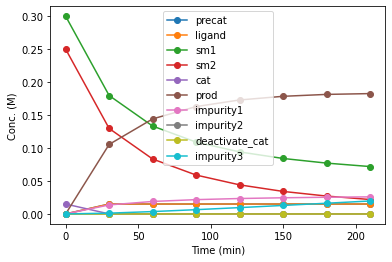

In [65]:
# ligands = ["L1", "L2", "L3", "L4"]
# solvents = ["S1", "S2", "S3", "S4"]

ligands = {
    # Best
    "L1": {
        "k": [2., 2., 0.5, 0.0015, 0.05, 0.05],
        "Ea": [30., 70., 70., 90., 85., 80.]
    },
    # Okay, forms less impurity1 but slower
    "L2": {
        "k": [2., 1., 0.05, 0.002, 0.005, 0.05],
        "Ea": [40., 70, 65, 90, 150, 80]
    },
    # Bad lots of impurity 1
    "L3": {
        "k": [2., 1., 2., 0.02, 0.005, 0.05],
        "Ea": [40., 40., 45., 80., 80., 80]
    },
    # Okay, forms lots of deactivated catalyst
    "L4": {
        "k": [2.0, 1., 0.01, 0.02, 4.0, 0.05],
        "Ea": [85., 50., 65., 80., 40., 80]
    },
    # Dead catalyst, nothing happens
    "L5": {
        "k": [2., 1e-3,1e-3,1e-3,1e-3, 0.05],
        "Ea": [40.,100.,100.,100.,100., 80]
    },
    # Almost dead catalyst
    "L6": {
        "k": [2., 0.1,1e-3,1e-3,1e-3, 0.05],
        "Ea": [40., 90.,100.,100.,100., 80,]
    },
    # Really slow catalyst, never gets past induction
    "L7": {
        "k": [0.001, 1e-4,1e-3,1e-3,1e-3, 0.05],
        "Ea": [70., 55,100.,100.,100., 80.]
    },
    # Slowish induction but otherwise good
    "L8": {
        "k": [0.001, 4., 0.5, 0.0015, 0.05, 0.05],
        "Ea": [60., 67., 70., 90., 85., 80.]
    },
}

solvents = {
    "S1": [1.0,1.5, 2., 1., 1., 0.8],  # Okay solvent, somewhat faster
    "S2": [1.0,2., 2., 5., 1., 1.], # Okay solvent, faster but hastens impurity 2 formation
    "S3": [1.0,4., 2., 1., 1., 0.5], # Best solvent, much faster
    "S4": [1.0,0.5, 0.5, 0.5, 0.5, 0.2], # Worst solvent, slows everything down
    "S5": [1.0,1.5, 2., 1.0, 1.5, 1.], # Okay solvent, accelerates catalyst deactivation
}

def rate(t, C, kV: list):
    # Concentrations
    precat = C[0]
    lig = C[1]
    sm1 = C[2]
    sm2 = C[3]
    cat = C[4]
    product = C[5]
    impurity_1 = C[6]
    impurity_2 = C[7]
    deactive_cat = C[8]
    impurity_3  = C[9]
    
    # Equations
    r = np.zeros(10)
    r[0] = kV[0]*cat
    r[1] = kV[0]*cat
    r[2] = -kV[1]*sm1*sm2*lig - kV[2]*sm1*sm2*lig 
    r[3] = -kV[1]*sm1*sm2*lig  - kV[2]*sm1*sm2*lig  - kV[3]*sm2
    r[4] = -kV[0]*cat-2*kV[4]*cat*cat 
    r[5] = kV[1]*sm1*sm2*lig - kV[5]*product
    r[6] = kV[2]*sm1*sm2*lig 
    r[7] = kV[3]*sm2
    r[8] = kV[4]*cat*cat
    r[9] = kV[5]*product
    return r
    

def react(
    ligand: str,
    solvent: str,
    temperature: float,
    res_time: float, 
    cat_conc: float,
    step_size: float = 15,
):
    # Constants
    C0 = [
        0.0, # Precat
        0.0, # Ligand
        0.3, #SM1
        0.25, #SM2
        0.003*cat_conc, #Catalyst
        0., #Product
        0., #impurity1
        0., #impurity2
        0., #deactivatecat
        0., #impurity3
    ]
    T = temperature + 273.15

    # Kinetic constants
    lig = ligands[ligand]
    k = lig["k"]
    Ea = lig["Ea"]
    AD = [7e9, 8.3e9, 8.5e9, 8e9, 8.8e9, 8e9]
    solvent_multipler = solvents[solvent]
    kV = [
        ADi*ki*np.exp(-Eai/(8.314e-3*T))
        for ADi, ki, Eai in zip(AD, k, Ea)
    ]
    kV = [
        kVi*solvent_multipler_i
        for kVi, solvent_multipler_i 
        in zip(kV, solvent_multipler)
    ]
    trange = np.arange(0, res_time, step_size)
    
    # Solve differential equation
    res = solve_ivp(
        rate,
        t_span=[0, res_time],
        y0=C0, 
        t_eval=trange,
        args=(kV,),
        method="LSODA",
    )
    return res.y.T

def run(
    ligand: str,
    solvent: str,
    temperature: float,
    res_time: float, 
    cat_conc: float,
    time_series: bool = True,
    step_size: float = 15,
):
    C = react(
        ligand=ligand, 
        solvent=solvent, 
        temperature=temperature, 
        res_time=res_time,
        cat_conc=cat_conc,
        step_size=step_size,
    )
    df = pd.DataFrame(
        C, 
        columns=[
            "precat",
            "ligand",
            "sm1",
            "sm2",
            "cat",
            "prod",
            "impurity1",
            "impurity2",
            "deactivate_cat",
            "impurity3",
        ]
    )
    trange = np.arange(0, res_time, step_size)
    df.index = trange
    return df

temp = 90
ligand= "L1"
df = run(
    ligand=ligand, 
    solvent="S3",
    temperature=temp,
    res_time=240, 
    cat_conc=5.0,
    step_size=30,
)
# print(1/(temp+273.15) + 1/303)
fig, ax = plt.subplots(1)
df.plot(marker="o", ax=ax)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Conc. (M)")
ax.legend(loc="upper center")

# Metrics
print(ligand, f"{temp}°C")
yld = df["prod"].iloc[-1]/df["sm2"].iloc[0] *100
print(f"Yield: {yld:0.02f}%" )
conv_sm1 = (df["sm1"].iloc[0]-df["sm1"].iloc[-1])/df["sm1"].iloc[0]*100
print(f"Conversion SM1: {conv_sm1:.02f}%")
conv_sm2 = (df["sm2"].iloc[0]-df["sm2"].iloc[-1])/df["sm2"].iloc[0]*100
print(f"Conversion SM2: {conv_sm2:.02f}%")
ligand_yld = df["ligand"].iloc[-1]/df["cat"].iloc[0]*100
print(f"Ligand yield: {ligand_yld:.02f}%")

L8 85°C
Yield: 78.92%
Conversion SM1: 76.87%
Conversion SM2: 92.93%
Ligand yield: 74.06%


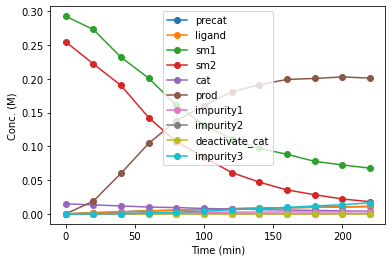

In [136]:
temp = 85
ligand= "L8"
exp = MultitaskKinetics.load_yaml("case_2_rand.yaml")
exp.noise_level = 2.0
df = exp._react(
    ligand=ligand, 
    solvent="S2", 
    temperature=temp, 
    res_time=240,
    cat_conc=5.0,
    step_size=20,
)

# Plot
fig, ax = plt.subplots(1)
df.plot(marker="o", ax=ax)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Conc. (M)")
ax.legend(loc="upper center")

# Metrics
print(ligand, f"{temp}°C")
yld = df["prod"].iloc[-1]/df["sm2"].iloc[0] *100
print(f"Yield: {yld:0.02f}%" )
conv_sm1 = (df["sm1"].iloc[0]-df["sm1"].iloc[-1])/df["sm1"].iloc[0]*100
print(f"Conversion SM1: {conv_sm1:.02f}%")
conv_sm2 = (df["sm2"].iloc[0]-df["sm2"].iloc[-1])/df["sm2"].iloc[0]*100
print(f"Conversion SM2: {conv_sm2:.02f}%")
ligand_yld = df["ligand"].iloc[-1]/df["cat"].iloc[0]*100
print(f"Ligand yield: {ligand_yld:.02f}%")

In [121]:
from yaml import load as yaml_load
from yaml import dump as yaml_dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

In [ ]:
with open("case_2.yaml", "r") as f:
    data = yaml_load(f, Loader=Loader)
for ligand, ligand_data in data["ligands"].items():
    ligand_data["k"] = (
        [round(lig_k*(1 + np.random.normal()*0.05), 4) for lig_k in ligand_data["k"][:-1]]
        + [ligand_data["k"][-1]]
    )
    ligand_data["Ea"] = [round(lig_ea*(1 + np.random.normal()*0.05), 4) for lig_ea in ligand_data["Ea"]]

In [52]:
exp.reset()
strategy = NewSTBO(
    exp.domain,
    categorical_method=None,
    brute_force_categorical=True,
    acquisition_function="UCB"
)
r = Runner(
    strategy=strategy, 
    experiment=exp, 
    max_iterations=20,
    num_initial_experiments=1,
)
r.run()

<AxesSubplot: >

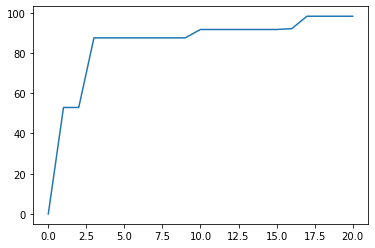

In [53]:
exp.data["yld"].cummax().plot()

In [54]:
exp.data

,ligand,solvent,temperature,res_time,cat_conc,yld,computation_t,experiment_t,strategy
0,L7,S3,82.5,195.0,2.0,0.027941,0.0,0.002146,LHS
1,L1,S3,47.5,105.0,4.0,52.913081,0.0,0.004235,LHS
2,L1,S3,38.538436,92.337542,4.465552,40.008774,31.695963,0.002987,STBO
3,L1,S3,69.200701,136.141528,2.867449,87.500701,30.071876,0.003584,STBO
4,L1,S3,96.756558,223.378684,1.119399,79.670566,0.899696,0.00387,STBO
5,L1,S4,78.358398,116.273647,2.684281,49.888296,0.8211,0.00317,STBO
6,L1,S2,78.087704,168.53093,2.236526,80.112996,0.890452,0.003531,STBO
7,L1,S3,31.964362,177.350376,4.580378,40.156569,0.934883,0.003179,STBO
8,L1,S5,30.0,240.0,2.130685,12.061841,10.01145,0.002951,STBO
9,L1,S1,79.343807,240.0,4.966483,72.748209,5.582604,0.003966,STBO


In [138]:
exp.domain

Name,Type,Description,Values
ligand,"categorical, input",Ligand for catalyst complex,8 levels
solvent,"categorical, input",Reaction solvent,5 levels
temperature,"continuous, input",Reaction temperature in degrees Celsius,"[30,100]"
res_time,"continuous, input",Residence time in minutes,"[60,240]"
cat_conc,"continuous, input",Catalyst concentration,"[1,5]"
yld,"continuous, maximize objective",Reaction yield,"[0,100]"


In [160]:
exp_ct = MultitaskKinetics.load_yaml("case_2.yaml")
exp_ct.noise_level = 2.0
strategy = FullFactorial(exp_ct.domain)
ligands=list(exp_ct.ligand_constants.keys())
solvents=list(exp_ct.solvent_constants.keys())
levels_dict = {
    "ligand": ligands,
    "solvent": solvents,
    "temperature": [100],
    "res_time": [60, 240],
    "cat_conc": [1,5]
}
suggestions = strategy.suggest_experiments(levels_dict)
ct_data = exp_ct.run_experiments(suggestions)
ct_data = ct_data.copy()
ct_data.loc[:, ("task", "METADATA")] = 0

In [ ]:
MultitaskKinetics.load_yaml("case_1.yaml")
exp.reset()
strategy = NewMTBO(
    exp.domain,
    pretraining_data=ct_data,
    task=1,
    # categorical_method=None,
    # brute_force_categorical=True,
    # acquisition_function="UCB"
)
r = Runner(
    strategy=strategy, 
    experiment=exp, 
    max_iterations=20,
    # num_initial_experiments=1,
)
r.run()